The aerodynamic heating model is a Python implementation of NASA program NQLD019. The following papers were used as references:

[1] - Method for Calculating Aerodynamic Heating
on Sounding Rocket Tangent Ogive Noses (https://arc.aiaa.org/doi/pdf/10.2514/3.62081) (Note that this paper appears to have a typo in Equation (20))

[2] - Tangent ogive nose aerodynamic heating program: NQLD019 (https://ntrs.nasa.gov/citations/19730063810) - Essentially the same as [1], but doesn't have the typo, and has more details and examples of the FORTRAN outputs

**Note that the program currently uses oblique shock relations (for a wedge) for the attached shock wave on the nosecone. It should technically use cone shock relations, but unfortunately I did not have time to implement cone shock functions at the time of writing. In this example, using oblique shocks instead of cone shocks seems to increase the maximum wall temperature very slightly.**

We will now show an example of how to perform a simple aerodynamic heating analysis. First import the modules we need:

In [1]:
import trajectory, trajectory.heating, trajectory.aero, csv
import numpy as np

#To make the plots interactive:
#%matplotlib notebook

To run an aerodynamic simulation, we must have already run a trajectory simulation and saved the output to a .JSON. We will now import that JSON:

In [2]:
trajectory_data = trajectory.from_json("data/trajectory.json")

The software needs the original rocket object that was used to generate the trajectory data. It needs this because it needs to do coordinate transforms on the trajectory data, and it needs information on the rocket's launch site to do this. 

Note that the actual details of the rocket (such as its mass, motor data, or aerodynamic coefficients) do not actually matter for the aerodynamic heating simulation. We just need the LaunchSite so that we can do coordinate transforms.

I've premade a file called martlet4.py which we can import a martlet4 Rocket object from:

In [3]:
from data.martlet4 import martlet4

Now we can start setting up an aerodynamic heating simulation. First we must define the nosecone shape, by creating a TangentOgive object:

In [4]:
tangent_ogive = trajectory.heating.TangentOgive(xprime = 73.7e-2, yprime = (19.7e-2)/2)

'xprime' is the length of the nosecone (tip to base), and 'yprime' is the base radius. See Fig 2. of https://arc.aiaa.org/doi/pdf/10.2514/3.62081 for a diagram.

We can now set up the aerodynamic heating simulation, and run a step. In this case, we'll use a variable wall temperature (as opposed to a fixed one), so we can roughly see how the temperature of the nosecone might vary:

In [5]:
analysis = trajectory.heating.AeroHeatingAnalysis(tangent_ogive, trajectory_data, martlet4,
                                        fixed_wall_temperature = False,
                                        starting_temperature = None,
                                        nosecone_mass = 1, 
                                        specific_heat_capacity = 900, 
                                        turbulent_transition_Rex = 7.5e6)   

#When we set starting_temperature = None, the programme sets the initial nosecone wall temperature to be atmospheric.

analysis.step(print_style="metric")


SUBCRIPTS:
0 or STAG  : At the stagnation point for a hemispherical nose
REF        : At 'reference' enthalpy and local pressure - I think this is like an average-ish boundary layer enthalpy
REC        : At 'recovery' enthalpy and local pressure - I believe this is the wall enthalpy at which no heat transfer takes place
W          : At the wall temperature and local pressure
INF        : Freestream (i.e. atmospheric) property
LAM        : With a laminar boundary layer
TURB       : With a turbulent boundary layer

FREE STREAM CONDITIONS
ALT =000.00 km    TINF=288.14 K    PINF=101.30 kPa    RHOINF=001.22 kg/m^3
VINF=000.00 m/s   MINF=000.00

Subsonic freestream flow, skipping step number 0


We can notice that (if it ran as expected), it printed the following at the bottom:

`Subsonic freestream flow, skipping step number 0`

This is because the simulation needs to try and model a shock wave at the nose tip, and if the rocket is subsonic, then there can't be a shockwave, so the step is skipped.

You may also sometimes get an output that says something like `Subsonic flow post-shock (Minf = {}, MS = {}), skipping step number {}`. The simulation needs to do a Prandtl-Meyer expansion after the nose shockwave, and this can only be done if the post-shock flow on the nosecone is supersonic. If this isn't the case, then the step is skipped.

We can run a set amount of steps using AeroHeatingAnalysis.run(number of steps). We'll then export the data to a .JSON file, using AeroHeatingAnalysis.to_json(directory)

In [6]:
analysis.run(number_of_steps = 300, starting_index = 0, print_style="minimal")
analysis.to_json("data/aero_heating_example.json")

0.0% complete, i = 0
10.0% complete, i = 30
20.0% complete, i = 60
30.0% complete, i = 90


D:\anaconda3\lib\site-packages\thermo\viscosity.py:826: RuntimeWarning:invalid value encountered in double_scalars
D:\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning:The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


40.0% complete, i = 120


D:\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning:The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.


50.0% complete, i = 150
60.0% complete, i = 180
70.0% complete, i = 210
80.0% complete, i = 240
90.0% complete, i = 270
100.0% complete, i = 300
Maximum wall temparature = 127.5094 °C
Minimum wall temperature = 14.9870 °C
Exported data to aero_heating_example.json


The `viscosity.py:826: RuntimeWarning:invalid value encountered in double_scalars` error is related to the `thermo` module, but doesn't seem to affect the results I think. I think `thermo` has some trouble calculating the viscosity for air in the conditions just after a shock wave.

If you already have data, and don't want to wait for the simulation to run, you can import it, as shown below:

In [7]:
analysis.from_json("data/aero_heating_example.json")

Now we'll make some nice plots of the data.

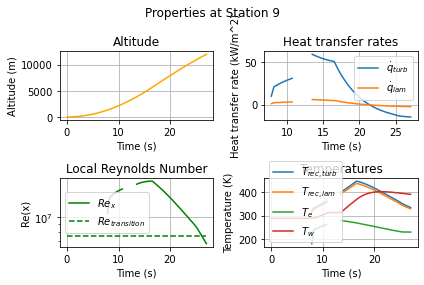

In [8]:
analysis.plot_station(station_number = 9, imax = 300)

The graphs below have an interactive slider at the bottom, which you can slide to vary the time since launch (by varying the index of the "time" array). This will only work if you have interactive graphs on, which is usually done automatically if you run your script from a code editor (e.g. VSCode or Spyder).

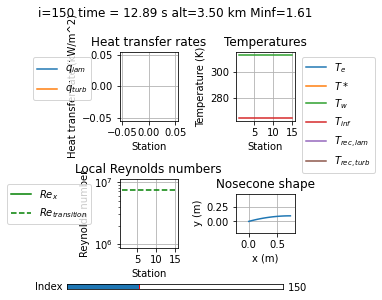

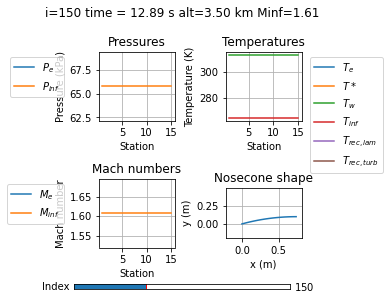

In [9]:
analysis.plot_heat_transfer(i = 150, automatic_rescaling=True)
analysis.plot_fluid_properties(i = 150, automatic_rescaling=True)

You can also manually make your own plots if you want:

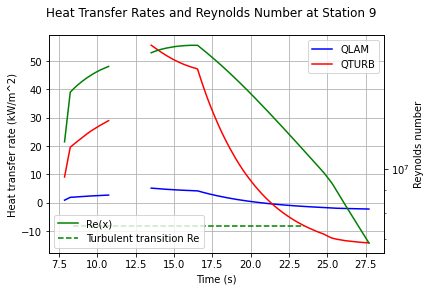

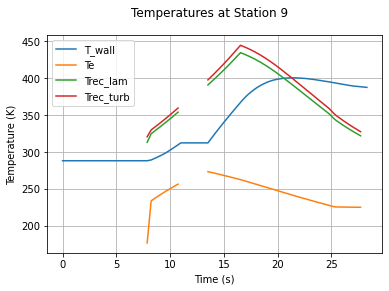

In [10]:
import matplotlib.pyplot as plt

#Plot the heat transfer rates
fig, ax1 = plt.subplots()
fig.suptitle("Heat Transfer Rates and Reynolds Number at Station 9")

#Plot heat transfer rates at Station 9
ax1.plot(analysis.trajectory_dict["time"], analysis.q_lam[9, :]/1000, label="QLAM", color="blue")
ax1.plot(analysis.trajectory_dict["time"], analysis.q_turb[9, :]/1000, label="QTURB", color="red")

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Heat transfer rate (kW/m^2)")
ax1.grid()
ax1.legend()

#Plot local Reynolds number using a different y-scale
ax2 = ax1.twinx()       #Second axes that shares the same x-axis as ax1
ax2.set_yscale("log")   #Make the scale logorithmic
ax2.plot(analysis.trajectory_dict["time"], analysis.Rex[9, :], label="Re(x)", color="green")
ax2.plot(analysis.trajectory_dict["time"][120:280], np.full(160, analysis.turbulent_transition_Rex), label="Turbulent transition Re", color="green", linestyle='--')
ax2.set_ylabel("Reynolds number")
ax2.legend(loc = 'lower left')

plt.show()

#Plot the temperatures
fig3, ax3 = plt.subplots()
fig3.suptitle("Temperatures at Station 9")

ax3.plot(analysis.trajectory_dict["time"], analysis.Tw[:], label="T_wall")
ax3.plot(analysis.trajectory_dict["time"], analysis.Te[9, :], label="Te")

#'Trec' means 'recovery temperature'. This means the same thing as 'adiabatic wall temperature'.
ax3.plot(analysis.trajectory_dict["time"], analysis.Trec_lam[9, :], label="Trec_lam")
ax3.plot(analysis.trajectory_dict["time"], analysis.Trec_turb[9, :], label="Trec_turb")

ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Temperature (K)")
ax3.grid()
ax3.legend()

plt.show()

Note that there are gaps in the graph. These correspond to when steps were skipped, due to subsonic pre-shock flow or subsonic post-shock flow, as explained earlier.

For modelling the temperature rise, the program has to decide at each station whether to use the laminar transfer heat rate or the turbulent one. If the local Reynolds number at a station is above the "Turbulent transition Re", then it assumes a turbulent boundary layer, and uses the turbulent heat transfer rate. Otherwise, it uses the laminar one.

If you're not sure what the "Station" numbers mean, they're just positions along the nosecone. 1 is at the nosecone tip, 11 is at the base of the nosecone, and 12-15 are downstream of the nosecone base. See Fig 1 and Fig 2 of https://arc.aiaa.org/doi/pdf/10.2514/3.62081 for a diagram.